## neuronal recurrente-LSTM

El aprendizaje profundo está muy implicado en el campo financiero cuantitativo moderno. Hay muchas redes neuronales diferentes que pueden aplicarse a los problemas de predicción del precio de las acciones. La red neuronal recurrente, para ser específicos, la red de memoria a largo plazo (LSTM) supera a otras arquitecturas ya que puede aprovechar la predicción de series de tiempo (o secuencialmente).  

Haremos una LSTM muy simple con Keras para predecir el precio de las acciones 

In [1]:
import numpy as np
np.random.seed(4)
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import style
import warnings

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

warnings.filterwarnings("ignore")
style.use('ggplot')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

**Instalamos yfinance**

In [2]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.7 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


**Usamos una función para graficar**

In [3]:
# Funciones auxiliares

def graficar_predicciones(real, prediccion):
    plt.plot(real[0:len(prediccion)],color='red', label='Valor real de la acción')
    plt.plot(prediccion, color='blue', label='Predicción de la acción')
    plt.ylim(1.1 * np.min(prediccion)/2, 1.1 * np.max(prediccion))
    plt.xlabel('Tiempo')
    plt.ylabel('Valor de la acción')
    plt.legend()
    plt.show()


**Cargamos los Datos**

In [4]:
import yfinance as yf

brk = yf.Ticker('MSFT') 

dataset = brk.history(period="max", auto_adjust=True)

dataset

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1986-03-13,0.056,0.064,0.056,0.061,1031788800,0.000,0.000
1986-03-14,0.061,0.064,0.061,0.063,308160000,0.000,0.000
1986-03-17,0.063,0.065,0.063,0.064,133171200,0.000,0.000
1986-03-18,0.064,0.065,0.062,0.063,67766400,0.000,0.000
1986-03-19,0.063,0.063,0.061,0.062,47894400,0.000,0.000
...,...,...,...,...,...,...,...
2022-08-10,288.170,289.810,286.940,289.160,24687800,0.000,0.000
2022-08-11,290.850,291.210,286.510,287.020,20065900,0.000,0.000
2022-08-12,288.480,291.910,286.940,291.910,22601900,0.000,0.000


In [5]:
dataset.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,9182.000,9182.000,9182.000,9182.000,9182.000,9182.000,9182.000
mean,38.701,39.106,38.282,38.711,58433986.148,0.003,0.002
std,64.356,65.008,63.657,64.373,38374894.191,0.043,0.059
min,0.056,0.058,0.056,0.057,2304000.000,0.000,0.000
25%,2.859,2.903,2.836,2.860,34279075.000,0.000,0.000
50%,19.014,19.209,18.844,19.003,51756750.000,0.000,0.000
75%,29.935,30.327,29.495,29.952,72227200.000,0.000,0.000
max,343.110,348.138,340.700,341.606,1031788800.000,3.080,2.000


**Dividimos los datos en train y test**

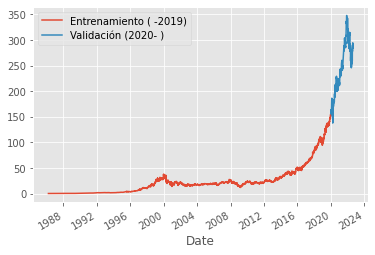

In [6]:
# Sets de entrenamiento y validación (test) 
# La LSTM se entrenará con datos de 2019 hacia atrás. La validación se hará con datos de 2020 en adelante.
# En ambos casos sólo se usará el valor más Alto de la acción para cada día
#
set_entrenamiento = dataset[:'2019'].iloc[:,1:2]
set_validacion = dataset['2020':].iloc[:,1:2]

set_entrenamiento['High'].plot(legend=True)
set_validacion['High'].plot(legend=True)
plt.legend(['Entrenamiento ( -2019)', 'Validación (2020- )'])
plt.show()

**Normalización del set de entrenamiento**

In [7]:
# Normalización del set de entrenamiento
sc = MinMaxScaler(feature_range=(0,1))
set_entrenamiento_escalado = sc.fit_transform(set_entrenamiento)

In [8]:
# La red LSTM tendrá como entrada "time_step" datos consecutivos, y como salida un dato (la predicción a
# partir de esos "time_step" datos). Se conformará de esta forma el set de entrenamiento
time_step = 60
X_train = []
Y_train = []
m = len(set_entrenamiento_escalado)

for i in range(time_step,m):
    # X: bloques de "time_step" datos: 0-time_step, 1-time_step+1, 2-time_step+2, etc
    X_train.append(set_entrenamiento_escalado[i-time_step:i,0])

    # Y: el siguiente dato
    Y_train.append(set_entrenamiento_escalado[i,0])
X_train, Y_train = np.array(X_train), np.array(Y_train)

# Reshape X_train para que se ajuste al modelo en Keras
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

**Red LSTM**

In [9]:
# Red LSTM

dim_entrada = (X_train.shape[1],1)
dim_salida = 1
na = 50

modelo = Sequential()
modelo.add(LSTM(units=na, input_shape=dim_entrada))
modelo.add(Dense(units=dim_salida))
#modelo.compile(optimizer='rmsprop', loss='mse')

modelo.compile(optimizer='rmsprop', loss='mse', metrics=['accuracy'])

modelo.fit(X_train,Y_train,epochs=20,batch_size=32)

Epoch 1/20
265/265 [==============================] - 7s 19ms/step - loss: 4.4875e-04 - accuracy: 1.1819e-04
Epoch 2/20
265/265 [==============================] - 8s 30ms/step - loss: 1.2211e-04 - accuracy: 1.1819e-04
Epoch 3/20
265/265 [==============================] - 9s 35ms/step - loss: 8.8658e-05 - accuracy: 1.1819e-04
Epoch 4/20
265/265 [==============================] - 7s 25ms/step - loss: 7.1783e-05 - accuracy: 1.1819e-04
Epoch 5/20
265/265 [==============================] - 5s 19ms/step - loss: 6.2972e-05 - accuracy: 1.1819e-04
Epoch 6/20
265/265 [==============================] - 5s 19ms/step - loss: 5.7347e-05 - accuracy: 1.1819e-04
Epoch 7/20
265/265 [==============================] - 5s 19ms/step - loss: 5.0752e-05 - accuracy: 1.1819e-04
Epoch 8/20
265/265 [==============================] - 5s 19ms/step - loss: 4.6866e-05 - accuracy: 1.1819e-04
Epoch 9/20
265/265 [==============================] - 6s 24ms/step - loss: 4.3748e-05 - accuracy: 1.1819e-04
Epoch 10/20
265/265

In [10]:
# Validación (predicción del valor de las acciones)
#
x_test = set_validacion.values
x_test = sc.transform(x_test)

X_test = []
for i in range(time_step,len(x_test)):
    X_test.append(x_test[i-time_step:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

prediccion = modelo.predict(X_test)
prediccion = sc.inverse_transform(prediccion)


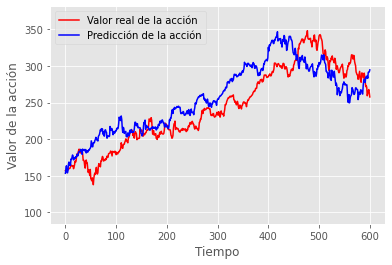

In [11]:
# Graficar resultados
graficar_predicciones(set_validacion.values,prediccion)

In [15]:
import math
trainScore = modelo.evaluate(X_train, Y_train, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)'% (trainScore[0], math.sqrt(trainScore[0])))

Train Score: 0.00 MSE (0.01 RMSE)
